# Part I

I will use the same VAE architecture as before but set the latent variable $z$ to be $\gamma \sim N(0, 30)$ and have the model predict allele age from $X_l$.  

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import tensorflow.keras.backend as kb
from tensorflow.keras.layers import Dense, Layer, Lambda, Multiply, Add

# Commonly used modules
import autograd.numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

In [63]:
#df1 = pd.read_csv("https://raw.githubusercontent.com/VivaswatS/selCoefEst/main/traindata/trip-2021-07-28.csv")
df1 = pd.read_csv("~/selCoefEst/traindata/trip-2021-07-28.csv")
dat = df1.to_numpy()
gamma = np.unique(dat[:,1])
idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]

In [64]:
dat

array([[ 8.800000e-03, -1.000000e+02,  3.810000e+02],
       [ 7.800000e-03, -6.812921e+01,  5.590000e+02],
       [ 1.200000e-03, -4.641589e+01,  3.690000e+02],
       ...,
       [ 9.876000e-01,  4.641589e+01,  2.631000e+03],
       [ 3.060000e-02,  6.812921e+01,  7.050000e+02],
       [ 8.898000e-01,  1.000000e+02,  1.044000e+03]])

In [4]:
from sklearn.model_selection import train_test_split
# 85/15 split - creating a training data set of only (Xl, al) - no gamma
temp = train_test_split(np.log(dat[:,(0,2)]), test_size=0.15, random_state=42)

train_data = temp[0][:,0]
train_labs = temp[0][:,1]
test_data = temp[1][:,0]
test_labs = temp[1][:,1]

In [509]:
# get indices of ECDF sims using same test_train split seed
sims = pd.read_csv("traindata/sims-2021-08-16.csv.gz", compression='gzip', header=None)

In [11]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

In [91]:
intermediate_dim = 1024
latent_dim = 32
batch_size = 512
epsilon_std = 1.0
sigma2sq = np.sqrt(20.0).astype('float32')

def mse(y_true, y_pred):
    return keras.backend.sum(keras.metrics.mean_squared_error(y_true, y_pred), axis=-1)

# when z (i.e., \gamma) ~ N(\mu_2=0, \sigma_2) - can only do one latent dimension
# class KLDivergenceLayer(Layer):
#     """ Identity transform layer that adds KL divergence to the final model loss.
#     """
#     def __init__(self, *args, **kwargs):
#         self.is_placeholder = True
#         super(KLDivergenceLayer, self).__init__(*args, **kwargs)

#     def call(self, inputs):
#         mu, log_var = inputs
#         kl_batch = keras.backend.log(sigma2sq) - log_var + .5 * (keras.backend.exp(log_var) + keras.backend.square(mu))/sigma2sq - .5

#         self.add_loss(keras.backend.mean(kl_batch), inputs=inputs)
#         return inputs

# when z ~ N(0, 1) - but can do multiple dimensions i.e., MVN(0, I)
class KLDivergenceLayer(Layer):
    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * keras.backend.sum(1 + log_var -
                                            keras.backend.square(mu) -
                                            keras.backend.exp(log_var), axis=-1)

        self.add_loss(keras.backend.mean(kl_batch), inputs=inputs)
        return inputs

# input is 1 dim - Xl
x = keras.Input(shape=(1,))
h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(512, activation='relu')(x)
h = Dense(256, activation='relu')(h)

gamma_mu = Dense(latent_dim)(h)
gamma_log_var = Dense(latent_dim)(h)

gamma_mu, gamma_log_var = KLDivergenceLayer()([gamma_mu, gamma_log_var])
gamma_sigma = Lambda(lambda t: keras.backend.exp(.5*t))(gamma_log_var)

eps = keras.Input(tensor=keras.backend.random_normal(stddev=epsilon_std, shape=(keras.backend.shape(x)[0], latent_dim)))
gamma_eps = Multiply()([gamma_sigma, eps])
gamma = Add()([gamma_mu, gamma_eps])

# only need 1 output dim - allele age
decoder = keras.Sequential([
    Dense(256, input_dim=latent_dim, activation='relu'), 
    Dense(512, input_dim=256, activation='relu'),
    Dense(intermediate_dim, input_dim=512, activation='relu'), 
    Dense(1, activation='relu')
])

x_pred = decoder(gamma)
# symbolic representation
encoder = keras.Model(x, outputs=[gamma_mu, gamma_sigma])

In [92]:
vae = keras.Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=mse)

history = vae.fit((train_data, np.random.randn(train_data.shape[0],latent_dim)), train_labs, epochs=5000, verbose=0, validation_split=0.1, shuffle=True,
                    validation_data=((test_data, np.random.randn(test_data.shape[0],latent_dim)), test_labs), callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


.................................................................

In [93]:
gamma_preds = encoder.predict(test_data)
preds_mean_vae = np.exp(np.ravel(decoder.predict(gamma_preds[0])))

In [94]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

plot_history()

In [80]:
plt.hist(gamma_preds[0])

(array([[   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0., 2031., 5469.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0., 1499., 6001.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [1447.,  654.,  877.,  768.,  787.,  834.,  634.,  688.,  262.,
          549.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.

Text(40000, 2500, 'Intercept = 5488.94')

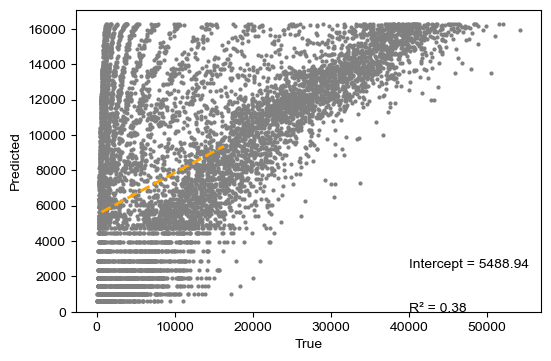

In [95]:
plt.figure(dpi=100)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.plot(np.exp(np.ravel(test_labs)), preds_mean_vae, 'o', color='grey', markersize=2)
plt.ylim(0)
res = sm.OLS(preds_mean_vae, sm.add_constant(np.exp(np.ravel(test_labs)))).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(preds_mean_vae), np.max(preds_mean_vae), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(40000, 10, "R² = {:.2f}".format(res.rsquared))
plt.text(40000, 2500, "Intercept = {:.2f}".format(muhat))

# Part II

Below, I will ask the BaselineNet to learn the parameters of a $N(\mu, \sigma^2=0.25)$ since the $\log(a_l)$ is distributed normally, compared to the raw allele ages that are $\Gamma$ distributed. 

In [65]:
# gamma = np.unique(dat[:,1])
# idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]
# temp = [train_test_split(dat[idx[i][0],0], dat[idx[i][0],2], test_size=0.15, random_state=42) for i in np.arange(len(gamma))]

# # for each gamma value...
# Xltrain = []
# Xltest = []
# altrain = []
# altest = []
# for t in np.arange(len(temp)):
#     Xltrain.append(temp[t][0])
#     Xltest.append(temp[t][1])
#     altrain.append(temp[t][2])
#     altest.append(temp[t][3])

# train_data = np.vstack((np.log(np.hstack(Xltrain[0:50])), np.repeat(gamma[0:50], len(Xltrain[0])))).T
# train_labs = np.log(np.hstack(altrain[0:50]))

# test_data = np.vstack((np.log(np.hstack(Xltest[0:50])), np.repeat(gamma[0:50], len(Xltest[0])))).T
# test_labs = np.log(np.hstack(altest[0:50]))

# train_data, test_data, train_labs, test_labs = train_test_split(np.vstack((np.log(dat[:,(0)]), dat[:,1])).T, np.log(dat[:,2]), test_size=0.15, random_state=42)

## only choose data that have negative gamma and choose few frequencies for testing
dat_red = dat[dat[:,1]<0,:]
# # subsetting gamma=-100 and -0.1
# dat_red = np.vstack((dat_red[dat_red[:,1]==-100,:],dat_red[dat_red[:,1]==-1,:]))

train_data, test_data, train_labs, test_labs = train_test_split(np.vstack((np.log(dat_red[:,0]), dat_red[:,1])).T, np.log(dat_red[:,2]), test_size=0.15, random_state=42)

In [66]:
plt.hist2d(train_data[:,0], train_labs, [20,20])
plt.colorbar()
plt.xlabel('log-freq')
plt.ylabel('log-age')

Text(0, 0.5, 'log-age')

(21250, 200)

In [925]:
sims_train, sims_test = train_test_split(sims.iloc[:,np.array(dat[:,1]<0)].T, test_size=0.15, random_state=42)

In [7]:
np.log(dat[:,1])

array([       nan,        nan,        nan, ..., 3.83764186, 4.22140605,
       4.60517019])

### Augmenting training data with more samples from the simulations

I will increase the size of the training data set by adding in 50 allele ages from the simulations to help with estimation of sd (i.e., each pair of $X_l,\gamma$ will have 50 samples of allele age). 

In [662]:
xlength = 25
for j in range(len(train_data)):
    train_data = np.append(train_data, np.repeat(dat[j,(0,1)],xlength).reshape(-1,2,order='F'), axis=0)
    train_labs = np.append(train_labs, np.log(sims_train.iloc[j,0:xlength]))

In [655]:
newtrain = np.append(train_data, np.repeat(dat[0,(0,1)],10).reshape(-1,2,order='F'), axis=0)

In [661]:
np.append(train_labs, np.log(sims_train.iloc[0,0:10]))

(42510,)

In [769]:
train_labs.shape

(1700,)

In [75]:
## NO IMPROVEMENT IN ESTIMATION BY INCREASING NUMBER OF HIDDEN LAYERS AND NODES
## TAKES LONGER TO CONVERGE WHEN USING SIGMOID VS RELU
x = keras.Input(shape=(2,))
h = Dense(64, activation='relu', kernel_initializer='random_uniform')(x)
h = Dense(32, activation='relu', kernel_initializer='random_uniform')(h)
params = Dense(2, kernel_initializer='random_uniform')(h)

## having just 1 free parameter works well...
# output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(tf.math.softplus(t[:,0]), 0.15))(params)

output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(t[...,:1], 2.*tf.math.exp(t[...,1:])))(params)

prob_model = keras.Model(inputs=x, outputs=output)

# def nll(yt, params):
#     dist = tfp.distributions.Normal(params, 1.0)
#     return tf.reduce_sum(-dist.log_prob(yt))
negloglik = lambda y, p_y: -tf.reduce_sum(p_y.log_prob(y))

#param_model = keras.Model(prob_model.input, params)

prob_model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negloglik)

(array([ 10.,  41., 117., 237., 299., 366., 452., 724., 880., 624.]),
 array([ 3.98898405,  4.68512945,  5.38127485,  6.07742025,  6.77356565,
         7.46971105,  8.16585645,  8.86200185,  9.55814726, 10.25429266,
        10.95043806]),
 <BarContainer object of 10 artists>)

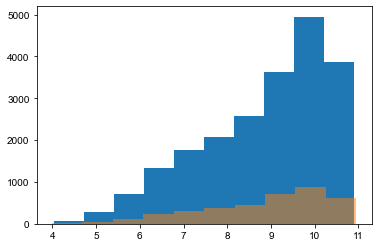

In [28]:
plt.hist(train_labs)
plt.hist(test_labs, alpha=0.5)

In [74]:
np.mean(test_labs)

3.734632249602328

In [68]:
prob_model.fit(train_data, train_labs, batch_size=512, epochs=5, shuffle=True)

Epoch 1/5
42/42 [==============================] - 0s 1ms/step - loss: 5160.3396
Epoch 2/5
42/42 [==============================] - 0s 1ms/step - loss: 2719.8920
Epoch 3/5
42/42 [==============================] - 0s 1ms/step - loss: 2084.0015
Epoch 4/5
42/42 [==============================] - 0s 1ms/step - loss: 1949.3936
Epoch 5/5
42/42 [==============================] - 0s 2ms/step - loss: 1830.7355


array([[-2.98380370e+00, -1.00000000e-01],
       [-7.82404601e+00, -2.15443500e-01],
       [-6.43775165e+00, -1.00000000e-01],
       ...,
       [-6.90775528e+00, -2.15443500e+01],
       [-3.98459370e+00, -3.16227800e+01],
       [-1.37515662e+00, -2.15443500e-02]])

In [76]:
history = prob_model.fit(train_data, train_labs, epochs=5000, batch_size=1024, verbose=0, validation_split=0.1, shuffle=True, callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


....................................................................................................
....................................................................................................
....................................................................................................
................................

In [77]:
ahat = prob_model(test_data)
preds = np.exp(ahat.mean().numpy())
preds_sd = ahat.stddev().numpy()

In [82]:
## save the model 
# prob_model.save('saved_model/lognorm_model')

INFO:tensorflow:Assets written to: saved_model/lognorm_model/assets


In [15]:
## read-in saved model (no retraining required)
prob_model = tf.keras.models.load_model('saved_model/lognorm_model')

ValueError: Unknown loss function: <lambda>

In [78]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Negative log-likelihood')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

plot_history()

(array([ 19.,  56., 122., 213., 253., 343., 403., 596., 772., 973.]),
 array([ 4.305308 ,  4.9372354,  5.5691633,  6.201091 ,  6.8330183,
         7.464946 ,  8.096873 ,  8.728802 ,  9.360729 ,  9.992657 ,
        10.624584 ], dtype=float32),
 <BarContainer object of 10 artists>)

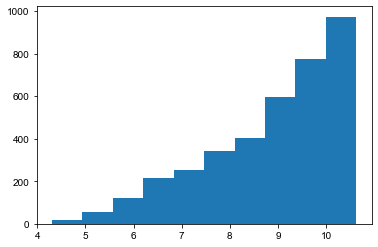

In [79]:
plt.hist(np.log(preds[:,0]))

In [74]:
plt.hist(preds)

(array([3316.,  260.,   66.,   28.,   21.,   13.,    8.,   15.,   14.,
           9.]),
 array([  12.648384,  225.70755 ,  438.7667  ,  651.82587 ,  864.885   ,
        1077.9442  , 1291.0033  , 1504.0625  , 1717.1217  , 1930.1808  ,
        2143.24    ], dtype=float32),
 <BarContainer object of 10 artists>)

## Diagnostic measures

Below, I have code to procude plots and statistics for accuracy measures 

Text(20000, 2500, 'Intercept = 473.36')

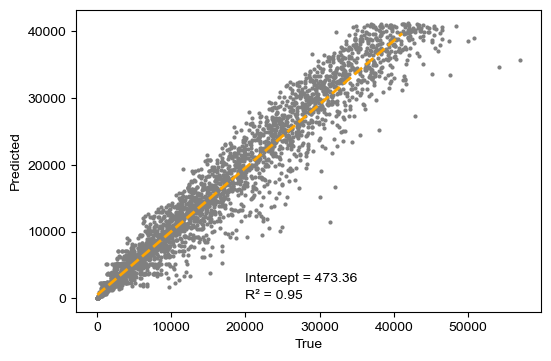

In [80]:
plt.figure(dpi=100)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.plot(np.exp(test_labs), preds, 'o', color='grey', markersize=2)
res = sm.OLS(preds, sm.add_constant(np.exp(test_labs))).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(preds), np.max(preds), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(20000, 2, "R² = {:.2f}".format(res.rsquared))
plt.text(20000, 2500, "Intercept = {:.2f}".format(muhat))

In [81]:
# check if true values fall within 95% CI of the estimates
inctr = np.full(len(test_labs), False, dtype='bool')
for i in range(len(test_labs)):
    lb, ub = np.exp(np.log(preds[i]) - 1.96*preds_sd[i]), np.exp(np.log(preds[i]) + 1.96*preds_sd[i])
    if np.exp(test_labs[i])>=lb and np.exp(test_labs[i])<=ub:
        inctr[i] = True

print('Accuracy: {:.2f}%'.format(100*np.sum(inctr)/len(test_labs)))

Accuracy: 96.13%


(array([ 4.,  3., 11.,  7., 29., 17., 11., 11.,  5.,  2.]),
 array([-0.39832688,  0.16097125,  0.72026937,  1.2795675 ,  1.83886562,
         2.39816375,  2.95746188,  3.51676   ,  4.07605813,  4.63535626,
         5.19465438]),
 <BarContainer object of 10 artists>)

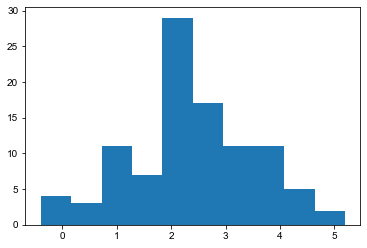

In [122]:
plt.hist(np.random.normal(np.log(preds[2345]),preds_sd[2345],100))

In [118]:
preds_sd[567]

array([1.1745207], dtype=float32)

(147, 1)

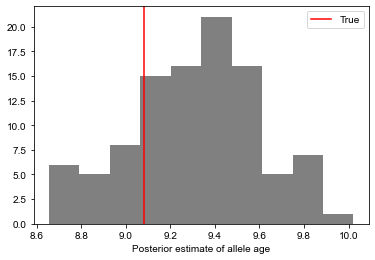

In [83]:
## plot histogram of samples of allele age...
plt.hist(np.random.normal(np.log(preds[4]),preds_sd[4],100), color="grey")
plt.xlabel('Posterior estimate of allele age')
plt.axvline(x=test_labs[4], color="red", label="True")
plt.legend()

In [1222]:
# writing results into file for analysis in R
np.savetxt('testdata/preds-{:s}.csv'.format(str(pd.to_datetime('today')).split(' ')[0]),np.hstack((test_data,preds,preds_sd)),delimiter=',')

In [1122]:
np.where(np.logical_and(test_data[:,0]>-1, test_data[:,1]==-100))

(array([ 249,  767,  901, 1018, 1098, 1334, 1518, 1605, 1886, 1912, 1972,
        2378, 2612, 3171, 3328]),)

(array([[ 16.,   0.,   0.,  11.,   0.,  13.,  19.,  16.,  19., 312.],
        [ 22.,   0.,   0.,  16.,   0.,  18.,  16.,  14.,  15., 293.],
        [ 10.,   0.,   0.,  18.,   0.,  22.,  11.,  16.,  14., 331.],
        [  8.,   0.,   0.,  13.,   0.,  23.,  15.,  17.,  15., 333.],
        [ 17.,   0.,   0.,  16.,   0.,  14.,  16.,  21.,  13., 270.],
        [ 10.,   0.,   0.,  19.,   0.,  15.,  17.,  12.,  12., 261.],
        [ 13.,   0.,   0.,  11.,   0.,  15.,  13.,  12.,   8., 245.],
        [ 11.,   0.,   0.,  10.,   0.,  19.,  16.,  14.,   6., 246.],
        [ 13.,   0.,   0.,  11.,   0.,  16.,  14.,  11.,   9., 225.],
        [ 13.,   0.,   0.,  11.,   0.,  21.,  21.,  22.,  17., 348.]]),
 array([-7.82404601e+00, -7.04174146e+00, -6.25943691e+00, -5.47713236e+00,
        -4.69482781e+00, -3.91252326e+00, -3.13021870e+00, -2.34791415e+00,
        -1.56560960e+00, -7.83305051e-01, -1.00050033e-03]),
 array([-1.0000e+02, -9.0001e+01, -8.0002e+01, -7.0003e+01, -6.0004e+01,
        -5.0

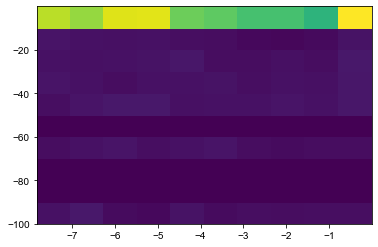

In [1196]:
def get_plot_kst(xl=None, delta=0.025, gamma=None):
    """function returns or plots ks-test value for a range of Xl, gamma or Xl and gamma, 
    needs to have sims_test and preds in the global environment"""
    if xl is None:
        idx = np.where(test_data[:,1]==gamma)[0]
        idx2 = np.where(kst[idx,1]<0.05)[0]
        plt.plot(np.exp(test_data[idx,0]), kst[idx,0], 'o', color='coral', label='not significant', alpha=0.3)
        plt.plot(np.exp(test_data[idx2,0]), kst[idx2,0], 'o', color='coral', label='p ≤ 0.05')
        plt.xlabel('Allele frequency')
        plt.ylabel('KS-test')
        plt.ylim((0,1))
        plt.title("gamma={:.3f}".format(gamma))
        plt.legend()
        return 0
    elif gamma is None:
        idx = np.where(np.logical_and(np.exp(test_data[:,0])>xl-delta, np.exp(test_data[:,0])<xl+delta))[0]
        idx2 = np.where(kst[idx,1]<0.05)[0]
        plt.plot(test_data[idx,1], kst[idx,0], 'o', color='coral', label='not significant', alpha=0.3)
        plt.plot(test_data[idx2,1], kst[idx2,0], 'o', color='coral', label='p ≤ 0.05')
        plt.title("Xl in ({:.2f}, {:.2f})".format(xl-delta,xl+delta))
        plt.xlabel('gamma')
        plt.ylim((0,1))
        plt.ylabel('KS-test')
        plt.legend()
        return 0

0

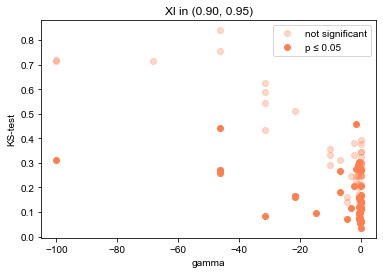

In [1199]:
get_plot_kst(xl=0.92)

0

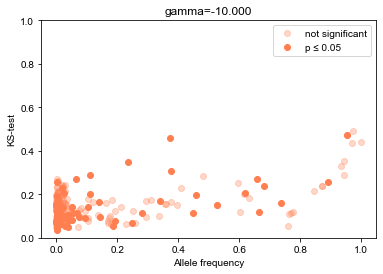

In [1172]:
get_plot_kst(gamma=-10.0)

In [16]:
## compare ECDFs of the true allele ages and estimated distributions (3 examples)
# find that SD=0.1 is not great for all allele ages (as expected...)
plt.figure(dpi=100, figsize=(6,10))
plt.subplot(311)
e1 = ECDF(np.exp(np.random.normal(np.log(preds[789,0]),preds_sd[789],200)))
plt.plot(e1.x, e1.y, color='salmon', label='Predicted')
plt.title(label=[np.exp(test_data[789,0]), test_data[789,1]])
e2 = ECDF(sims_test.iloc[789,:])
plt.plot(e2.x, e2.y, color='grey', label='True')
plt.legend()

plt.subplot(312)
e1 = ECDF(np.exp(np.random.normal(np.log(preds[1660,0]),preds_sd[1660],200)))
plt.plot(e1.x, e1.y, color='salmon', label='Predicted')
plt.title(label=[np.exp(test_data[1660,0]), test_data[1660,1]])
e2 = ECDF(sims_test.iloc[1660,:])
plt.plot(e2.x, e2.y, color='grey', label='True')
plt.legend()

plt.subplot(313)
e1 = ECDF(np.exp(np.random.normal(np.log(preds[3738,0]),preds_sd[3738],200)))
plt.plot(e1.x, e1.y, color='salmon', label='Predicted')
plt.title(label=[np.exp(test_data[3738,0]), test_data[3738,1]])
plt.xlabel('allele age (gens)')
e2 = ECDF(sims_test.iloc[3738,:])
plt.plot(e2.x, e2.y, color='grey', label='True')
plt.legend()

NameError: name 'sims_test' is not defined

In [85]:
plt.plot(preds, preds_sd, 'o', color='grey', markersize=2)

In [86]:
kst = np.empty((len(test_labs),2))
for i in range(len(test_labs)):
    kst[i,:] = scipy.stats.kstest(np.exp(np.random.normal(np.log(preds[i]),preds_sd[i],200)),sims_test.iloc[i,:])

NameError: name 'sims_test' is not defined

In [977]:
# query indices with highest kst (ONLY significant values)
kst_sig = np.where(np.logical_and(kst[:,1]<0.05, kst[:,0]>0.25))[0]
h_kst = plt.hist2d(test_data[kst_sig,0],test_data[kst_sig,1], [20,20])
plt.ylim((-100,0))
plt.xlabel('log-frequency')
plt.ylabel('gamma')
plt.title('KS-test value > 0.25')

Text(0.5, 1.0, 'KS-test value > 0.25')

In [1186]:
h_full = plt.hist2d(train_data[:,0],train_data[:,1], [20,20])
plt.title('Number of data points in each bin')
plt.xlabel('log-frequency')
plt.ylabel('gamma')
plt.colorbar()

In [1096]:
# check if .mean() and .stddev() return params or empirical values?
param_model = keras.Model(prob_model.input, params)
params = param_model(test_data)

0.999999999999997
1.0


Text(0, 0.5, 'Mean from output layer')

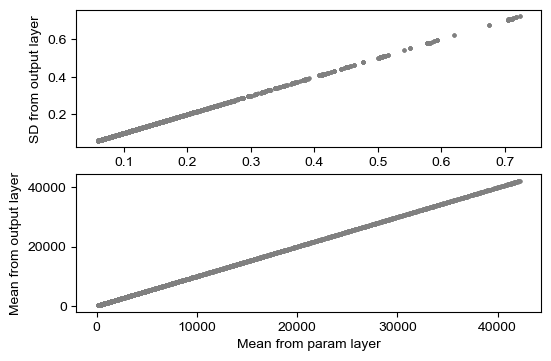

In [1098]:
# Correlation of 1 between the the two, NO NEED FOR param_model
plt.figure(dpi=100)
plt.subplot(211)
# param output is log var NOT sd
print(np.corrcoef(2.*np.exp(params[:,1].numpy()), preds_sd.T)[0,1])
plt.plot(2.*np.exp(params[:,1].numpy()), preds_sd, 'o', color='grey', markersize=2)
plt.xlabel('SD from param layer')
plt.ylabel('SD from output layer')
plt.subplot(212)
print(np.corrcoef(np.exp(params[:,0].numpy()), preds.T)[0,1])
plt.plot(np.exp(params[:,0].numpy()), preds, 'o', color='grey', markersize=2)
plt.xlabel('Mean from param layer')
plt.ylabel('Mean from output layer')

450 more pairs have significant differences with sd=0.25 when compared to sd=0.1 (best in test, increases again drastically for sd=0.05 and a little bit for sd=0.15) 


But decreasing the sd we see that a smaller percentage of 'true' values fall within the 95% CI of the estimate...seems like there is a balance at sd=0.15   

Again lowest accuracy when $|\gamma| < 0.02$ and $X_l < 5 \times 10^{-4}$ 

In [885]:
len(np.where(kst[:,1]<0.05)[0])

3120

In [963]:
np.where(np.logical_and(kst[:,1]<0.05, kst[:,0]>0.25))[0]

array([   0,    2,    3, ..., 7489, 7494, 7498])

In [502]:
scipy.stats.kstest(np.random.normal(pred_params[57,0],0.25,200),np.random.normal(pred_params[55,0],0.25,200))

0.205

In [473]:
np.linspace(0,1,200)

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

# Part III

Below, I will model the allele ages as coming from a $\Gamma(\alpha, \beta) = x^{\alpha - 1} e^{-x \beta} \beta^{\alpha}/ \Gamma(\alpha)$ distribution given $X_l$ and $\gamma$. The loss function needs to be defined as a negative log-likelihood of the $\Gamma$ distribution...

In [978]:
train_data = np.vstack((np.log(np.hstack(Xltrain[0:50])), np.repeat(gamma[0:50], len(Xltrain[0])))).T
train_labs =np.hstack(altrain[0:50])

test_data = np.vstack((np.log(np.hstack(Xltest[0:50])), np.repeat(gamma[0:50], len(Xltest[0])))).T
test_labs = np.hstack(altest[0:50])

(array([1.6203e+04, 6.8680e+03, 5.2150e+03, 4.2460e+03, 3.6850e+03,
        3.2470e+03, 2.3710e+03, 5.9200e+02, 6.5000e+01, 8.0000e+00]),
 array([5.40000e+01, 6.01670e+03, 1.19794e+04, 1.79421e+04, 2.39048e+04,
        2.98675e+04, 3.58302e+04, 4.17929e+04, 4.77556e+04, 5.37183e+04,
        5.96810e+04]),
 <BarContainer object of 10 artists>)

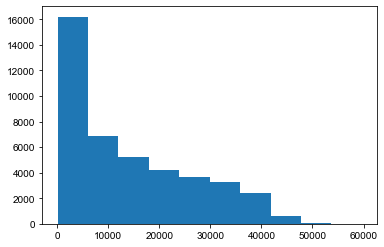

In [980]:
plt.hist(train_labs)

In [1027]:
x = keras.Input(shape=(2,))
h = Dense(500, activation='relu', kernel_initializer='random_uniform')(x)
h = Dense(250, activation='relu', kernel_initializer='random_uniform')(h)
h = Dense(100, activation='relu', kernel_initializer='random_uniform')(h)
params = Dense(2, kernel_initializer='random_uniform')(h)

#output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Gamma(concentration=tf.math.softplus(t[...,:1]), rate=tf.math.softplus(t[...,1:])))(params)
output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(tf.math.softplus(t[...,:1]), tf.math.softplus(t[...,1:])))(params)

prob_model = keras.Model(inputs=x, outputs=output)

# def nll(yt, params):
#     dist = tfp.distributions.Normal(params, 1.0)
#     return tf.reduce_sum(-dist.log_prob(yt))
negloglik = lambda y, p_y: -tf.reduce_sum(p_y.log_prob(y))

prob_model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negloglik)

In [1026]:
prob_model.fit(train_data, train_labs, batch_size=512, epochs=2, shuffle=True)

Epoch 1/2
84/84 [==============================] - 1s 4ms/step - loss: nan
Epoch 2/2
84/84 [==============================] - 0s 4ms/step - loss: nan


In [990]:
train_data.shape

(42500, 2)

In [1028]:
history = prob_model.fit(train_data, train_labs, epochs=500, batch_size=1024, verbose=0, validation_split=0.1, shuffle=True, callbacks=[PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

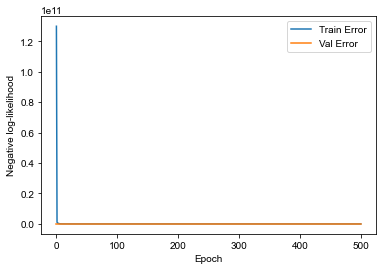

In [1029]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Negative log-likelihood')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

plot_history()

In [1036]:
param_model = keras.Model(x, params)
params = param_model(test_data)
preds_co = params[:,0].numpy()
preds_ra = params[:,1].numpy()

ValueError: Output tensors of a Functional model must be the output of a TensorFlow `Layer` (thus holding past layer metadata). Found: tf.Tensor(
[[  660.0951    332.17987]
 [  247.32854   135.85483]
 [  670.64294   337.14392]
 ...
 [33396.2     44298.305  ]
 [36733.99    47197.156  ]
 [35662.78    46265.32   ]], shape=(7500, 2), dtype=float32)

array([inf, inf, inf, ..., inf, inf, inf], dtype=float32)

Text(40000, 2500, 'Intercept = 1163.16')

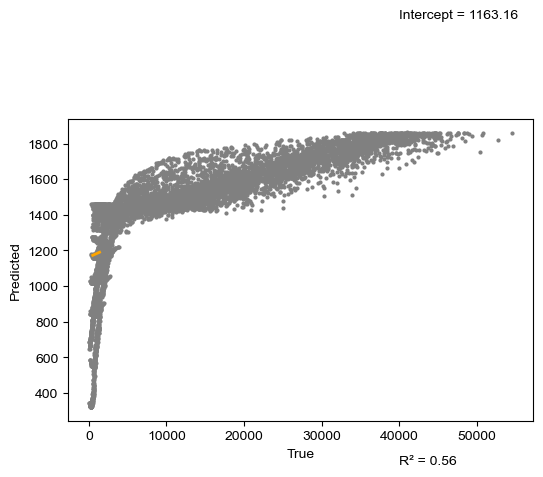

In [442]:
plt.figure(dpi=100)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.plot(test_labs, pred_params[:,0], 'o', color='grey', markersize=2)
res = sm.OLS(pred_params[:,0], sm.add_constant(test_labs)).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(pred_params[:,0]), np.max(pred_params[:,0]), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(40000, 2, "R² = {:.2f}".format(res.rsquared))
plt.text(40000, 2500, "Intercept = {:.2f}".format(muhat))

## Part IV

In this section, I will test the hypothesis that by conditioning on allele age AND allele frequency we get a better likelihood estimate for selection coefficient than just conditioning on allele frequency. Naively, this means looking at the curvature of the log-likelihood surface around the estimate (say $\gamma=-10.0$) for the two different distributions: $p(\gamma | X_l)$ and $p(\gamma | X_l, a_l) = p(X_l | \gamma) p(a_l | X_l, \gamma)$. 

$$f(X_l | \gamma) = \frac{1}{X_l(1-X_l)}\frac{1-e^{-2\gamma(1-X_l)}}{1-e^{-2\gamma}}$$

In [293]:
import jax.numpy as jnp
from jax import jacrev, jacfwd, hessian
import jax

In [285]:
# subset data for a specific value of gamma=-10
Xlred = np.ravel(np.exp(test_data[np.where(test_data[:,1]==-10),0]))
logalred = test_labs[np.where(test_data[:,1]==-10)]

In [276]:
def get_ll_xl(g):
    """function to compute L(gamma|Xl), where gamma is a range of values and Xl is a given set of freqs"""
    xl = Xlred#params[1]
    #N = params[2]
    res = 0.0
    ub = scipy.special.expi(-g*0.5/N) - np.exp(-g)*scipy.special.expi(g*(1-0.5/N)) - np.log(0.5/N) + np.log(1-0.5/N)
    lb = scipy.special.expi(g*(0.5/N-1)) - np.exp(-g)*scipy.special.expi(g*0.5/N) - np.log(1-0.5/N) + np.log(0.5/N)
    scalfact = np.log((ub - lb)/(1-np.exp(-g)))
    for x in xl:
        res += -np.log(x) - np.log(1.-x) + np.log((1.-np.exp(-2.*g*(1.-x)))/(1.-np.exp(-2.*g))) / scalfact
    #res = np.sum(-np.log(xl) - np.log(1.-xl) + np.log((1.-np.exp(-2.*g*(1.-xl)))/(1.-np.exp(-2.*g)))) / scalfact
    return res

In [296]:
# def get_ll_xl(gamma, xl, N=2500):
#     """function to compute L(gamma|Xl), where gamma is a range of values and Xl is a given set of freqs"""
#     res = np.zeros(len(gamma))
#     for i, g in enumerate(gamma):
#         ub = scipy.special.expi(-g*0.5/N) - np.exp(-g)*scipy.special.expi(g*(1-0.5/N)) - np.log(0.5/N) + np.log(1-0.5/N)
#         lb = scipy.special.expi(g*(0.5/N-1)) - np.exp(-g)*scipy.special.expi(g*0.5/N) - np.log(1-0.5/N) + np.log(0.5/N)
#         scalfact = np.log((ub - lb)/(1-np.exp(-g)))
#         for x in xl:
#             res[i] += -np.log(x) - np.log(1-x) + np.log((1-np.exp(-2.*g*(1-x)))/(1-np.exp(-2.*g))) / scalfact
#     return np.array(res)

# def get_ll_xl_torch(g):
#     """function to compute L(gamma|Xl), where gamma is a range of values and Xl is a given set of freqs"""
#     xl = torch.tensor(Xlred)#params[1]
#     #N = params[2]
#     res = 0.0
#     ub = scipy.special.expi(-g.detach().numpy()*0.5/N) - g.exp()*scipy.special.expi(g.detach().numpy()*(1-0.5/N)) - np.log(0.5/N) + np.log(1-0.5/N)
#     lb = scipy.special.expi(g.detach().numpy()*(0.5/N-1)) - (-g).exp()*scipy.special.expi(g.detach().numpy()*0.5/N) - np.log(1-0.5/N) + np.log(0.5/N)
#     scalfact = (ub - lb)/(1-(-g).exp())
#     for x in xl:
#         res += -x.log() - (1.-x).log() + np.log((1.-np.exp(-2.*g.detach().numpy()*(1.-x)))/(1.-np.exp(-2.*g.detach().numpy()))) 
#     #res = (-xl.log() - (1.-xl).log() + ((1.-(-2.*g*(1.-xl)).exp())/(1.-(-2.*g).exp())).log()).sum() / scalfact
#     return torch.tensor(res / scalfact.log())

def get_ll_xl_jax(g):
    xl = Xlred
    res = 0.0
    ub = jax.scipy.special.expi(-g*0.5/N) - jnp.exp(-g)*jax.scipy.special.expi(g*(1-0.5/N)) - jnp.log(0.5/N) + jnp.log(1-0.5/N)
    lb = jax.scipy.special.expi(g*(0.5/N-1)) - jnp.exp(-g)*jax.scipy.special.expi(g*0.5/N) - jnp.log(1-0.5/N) + jnp.log(0.5/N)
    scalfact = jnp.log((ub - lb)/(1-jnp.exp(-g)))
    for x in xl:
        res += -jnp.log(x) - jnp.log(1.-x) + jnp.log((1.-jnp.exp(-2.*g*(1.-x)))/(1.-jnp.exp(-2.*g))) 
    #res = np.sum(-np.log(xl) - np.log(1.-xl) + np.log((1.-np.exp(-2.*g*(1.-xl)))/(1.-np.exp(-2.*g)))) / scalfact
    return res / scalfact

In [304]:
#print(get_ll_xl_jax(-10.))
jax.hessian(get_ll_xl_jax)(-10.)
#jacrev(jacfwd(get_ll_xl_jax))(-10.) - same as above

DeviceArray(-0.70399547, dtype=float32)

In [246]:
gt.detach().numpy()

array(-10., dtype=float32)

In [218]:
ub=scipy.special.expi(-gt.detach().numpy()*0.5/N) - gt.exp()*scipy.special.expi(gt.detach().numpy()*(1-0.5/N)) - np.log(0.5/N) + np.log(1-0.5/N)
lb=scipy.special.expi(gt.detach().numpy()*(0.5/N-1)) - (-gt).exp()*scipy.special.expi(gt.detach().numpy()*0.5/N) - np.log(1-0.5/N) + np.log(0.5/N)
np.log(((ub - lb)/(1-np.exp(-g))))

tensor(1.7496)

In [241]:
g=-0.01
ub = scipy.special.expi(-g*0.5/N) - np.exp(-g)*scipy.special.expi(g*(1-0.5/N)) - np.log(0.5/N) + np.log(1-0.5/N)
lb = scipy.special.expi(g*(0.5/N-1)) - np.exp(-g)*scipy.special.expi(g*0.5/N) - np.log(1-0.5/N) + np.log(0.5/N)
scalfact = np.log((ub - lb)/(1-np.exp(-g)))

In [242]:
scalfact

2.141476366146837

In [236]:
hes_ = hessian(get_ll_xl)
hes_(-10.)

array(-0.0915572)

In [280]:
get_ll_xl(-100.)

-2122.0780276612313

In [106]:
N=2500
g=-1
print(scipy.special.expi(g*-0.5/N) - np.exp(-g)*scipy.special.expi(g*(1-0.5/N)) - np.log(0.5/N) + np.log(1-0.5/N))
scipy.special.expi(g*(0.5/N-1)) - np.exp(-g)*scipy.special.expi(g*0.5/N) - np.log(1-0.5/N) + np.log(0.5/N)

1.1737630572291722


14.961221246455251

In [ ]:
plt.hist(np.ravel(np.exp(test_data[np.where(test_data[:,1]==-0.1),0])))
plt.hist(Xlred,alpha=0.3)

In [252]:
# def get_ll_alxl(gamma, Xlred, lalred, model):
#     """function to compute L(gamma|Xl,al), where gamma is a range of values and Xl & al are given sets of freqs and ages"""
#     res = np.zeros(len(gamma))
#     for ig, g in enumerate(gamma):
#         ahat = model(np.vstack((np.log(Xlred),np.repeat(g,len(Xlred)))).T)
#         preds = ahat.mean().numpy()
#         preds_sd = ahat.stddev().numpy()
#         for ia, a in enumerate(lalred):
#             res[ig] += scipy.stats.norm.logpdf(a, loc=preds[ia], scale=preds_sd[ia]) 
#     return res

def get_ll_alxl(g):
    """function to compute L(gamma|Xl,al), where gamma is a range of values and Xl & al are given sets of freqs and ages"""
    res = 0.0
    #g = params[0]
    #Xlred = params[1]
    #lalred = params[2]
    #model = params[3]

    ahat = prob_model(np.vstack((np.log(Xlred),np.repeat(g,len(Xlred)))).T)
    preds = ahat.mean().numpy()
    preds_sd = ahat.stddev().numpy()
    for ia, a in enumerate(logalred):
        res += scipy.stats.norm.logpdf(a, loc=preds[ia], scale=preds_sd[ia]) 
    return res

In [239]:
get_ll_alxl(-10.)

array([-216.60181293])

In [162]:
test_data[np.where(test_data[:,1]==-100),0].T.shape

(133, 1)

In [180]:
#np.vstack((Xlred,np.repeat(g,len(Xlred)))).T.shape
#np.hstack((test_labs[np.where(test_data[:,1]==-100)],test_labs[np.where(test_data[:,1]==-10)])).T.shape
np.max([get_ll_alxl([g, Xlred, logalred, prob_model]) for g in [-100,-10,-1]]) #+ get_ll_xl([-100,-10,-1], Xlred)

-216.60181293204752

### Plotting the log-likelihood surfaces 

In [193]:
gamma[gamma<0]

array([-1.000000e+02, -6.812921e+01, -4.641589e+01, -3.162278e+01,
       -2.154435e+01, -1.467799e+01, -1.000000e+01, -6.812921e+00,
       -4.641589e+00, -3.162278e+00, -2.154435e+00, -1.467799e+00,
       -1.000000e+00, -6.812921e-01, -4.641589e-01, -3.162278e-01,
       -2.154435e-01, -1.467799e-01, -1.000000e-01, -6.812921e-02,
       -4.641589e-02, -3.162278e-02, -2.154435e-02, -1.467799e-02,
       -1.000000e-02])

In [42]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [273]:
def plot_func(N, g):
    Xlred = np.ravel(np.exp(test_data[np.where(test_data[:,1]==g),0]))
    logalred = test_labs[np.where(test_data[:,1]==g)]

    logxl = np.ravel([get_ll_xl([g, Xlred, N]) for g in gamma[gamma<0]])
    logxlal = np.ravel([get_ll_alxl([g, Xlred, logalred, prob_model]) for g in gamma[gamma<0]])
    fig = plt.figure(dpi=100)
    _ = plt.semilogx(gamma[gamma<0], logxl-np.max(logxl), color='k', label='L(gamma; Xl)')
    plt.xscale('symlog')
    _ = plt.semilogx(gamma[gamma<0], logxlal-np.max(logxlal), color='b', label='L(gamma; Xl, al)')
    plt.xscale('symlog')
    plt.axvline(x=g, linestyle='--', color='red', label='true value')
    plt.xlabel('gamma')
    plt.ylabel('scaled log-likelihood')
    plt.legend()
    plt.grid()
    plt.ylim((-20,0))
    return fig

interact(plot_func, N=widgets.IntSlider(value=N, min=10, max=500), g=gamma[gamma<0])

interactive(children=(IntSlider(value=500, description='N', max=500, min=10), Dropdown(description='g', option…

<function __main__.plot_func(N, g)>

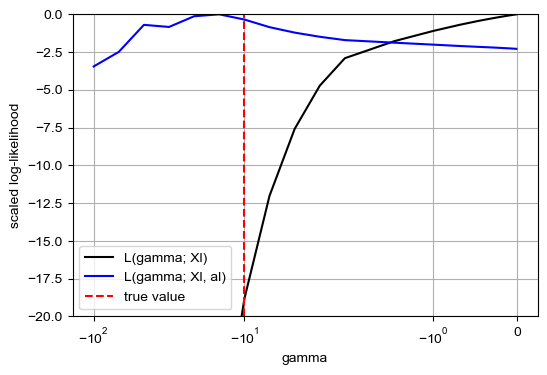

In [184]:
Xlred = np.ravel(np.exp(test_data[np.where(test_data[:,1]==-10),0]))
logalred = test_labs[np.where(test_data[:,1]==-10)]

logxl = np.ravel([get_ll_xl([g, Xlred, N]) for g in gamma[gamma<0]])
logxlal = np.ravel([get_ll_alxl([g, Xlred, logalred, prob_model]) for g in gamma[gamma<0]])
fig = plt.figure(dpi=100)
_ = plt.semilogx(gamma[gamma<0], logxl-np.max(logxl), color='k', label='L(gamma; Xl)')
plt.xscale('symlog')
_ = plt.semilogx(gamma[gamma<0], logxlal-np.max(logxlal), color='b', label='L(gamma; Xl, al)')
plt.xscale('symlog')
plt.axvline(x=-10., linestyle='--', color='red', label='true value')
plt.xlabel('gamma')
plt.ylabel('scaled log-likelihood')
plt.legend()
plt.ylim((-20,0))
plt.grid()

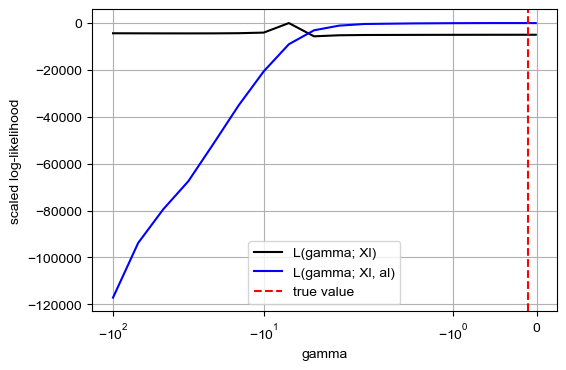

In [36]:
## choosing a different value for true gamma (-0.1)
Xlred = np.ravel(np.exp(test_data[np.where(test_data[:,1]==-0.1),0]))
logalred = test_labs[np.where(test_data[:,1]==-0.1)]

logxl = get_ll_xl(gamma[gamma<0], Xlred, N=10)
logxlal = get_ll_alxl(gamma[gamma<0], Xlred, logalred, prob_model)
plt.figure(dpi=100)
plt.semilogx(gamma[gamma<0], logxl-np.max(logxl), color='k', label='L(gamma; Xl)')
plt.xscale('symlog')
plt.semilogx(gamma[gamma<0], logxlal-np.max(logxlal), color='b', label='L(gamma; Xl, al)')
plt.xscale('symlog')
plt.axvline(x=-0.1, linestyle='--', color='red', label='true value')
plt.xlabel('gamma')
plt.ylabel('scaled log-likelihood')
plt.legend()
plt.grid()

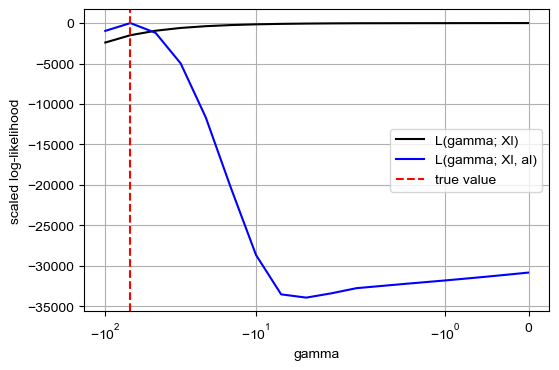

In [29]:
Xlred = np.ravel(np.exp(test_data[np.where(test_data[:,1]==-6.812921e+01),0]))
logalred = test_labs[np.where(test_data[:,1]==-6.812921e+01)]

logxl = get_ll_xl(gamma[gamma<0], Xlred)
logxlal = get_ll_alxl(gamma[gamma<0], Xlred, logalred, prob_model)
plt.figure(dpi=100)
plt.semilogx(gamma[gamma<0], logxl-np.max(logxl), color='k', label='L(gamma; Xl)')
plt.xscale('symlog')
plt.semilogx(gamma[gamma<0], logxlal-np.max(logxlal), color='b', label='L(gamma; Xl, al)')
plt.xscale('symlog')
plt.axvline(x=-6.812921e+01, linestyle='--', color='red', label='true value')
plt.xlabel('gamma')
plt.ylabel('scaled log-likelihood')
plt.legend()
plt.grid()

### Computing the observed Fisher information

Yudi Pawitan writes in https://rads.stackoverflow.com/amzn/click/com/0199671222 that the second derivative of the log-likelihood evaluated at the maximum likelihood estimates (MLE) is the observed Fisher information. The estimated standard errors of the MLE (in Hessian) are the square roots of the diagonal elements of the inverse of the observed Fisher information matrix.

In [87]:
import numpy.linalg as lin
from autograd import grad, jacobian, hessian
from scipy.optimize import minimize

In [112]:
# Xlred = np.ravel(np.exp(test_data[np.where(test_data[:,1]==-10),0]))
# logalred = test_labs[np.where(test_data[:,1]==-10)]

hes_ = hessian(get_ll_xl)

# mle_gamma = gamma[gamma<0][np.argmax([get_ll_xl(g) for g in gamma[gamma<0]])]

# transpose or no transpose - same (1x1 matrix cos only 1 param)
# information1 = np.transpose(hes_(mle_gamma))

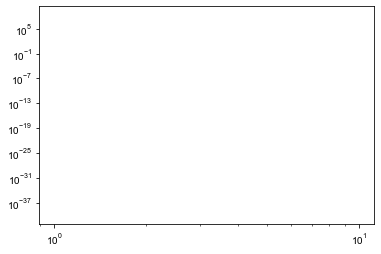

In [104]:
plt.loglog(gamma[gamma<0], np.ravel(hes_across_g), color='k')
#hes_across_g = [hes_(x) for x in gamma[gamma<0]]

In [100]:
hes_across_g

[array(2.1323194e-40),
 array(7.96603265e-27),
 array(1.44075237e-17),
 array(2.55690896e-11),
 array(4.02847496e-07),
 array(0.00025204),
 array(0.01731471),
 array(0.26103085),
 array(1.42278581),
 array(4.35289682),
 array(11.45184531),
 array(32.84839689),
 array(101.47341186),
 array(320.16321807),
 array(1013.12221928),
 array(3205.37955723),
 array(10138.4743825),
 array(32063.22008521),
 array(101395.47487472),
 array(320643.45609655),
 array(1013966.60360839),
 array(3206446.23890502),
 array(10139675.22579973),
 array(32064502.87289842),
 array(1.01396809e+08)]

In [253]:
hes2_ = hessian(get_ll_alxl)

tt = np.zeros(len(gamma[gamma<0]))
for i, g in enumerate(gamma[gamma<0]):
    ahat = prob_model(np.vstack((np.log(Xlred),np.repeat(g,len(Xlred)))).T)
    preds = ahat.mean().numpy()
    preds_sd = ahat.stddev().numpy()
    tt[i] = get_ll_alxl(g)

mle2_gamma = gamma[gamma<0][np.argmax(res)]

information2 = np.transpose(hes2_(mle2_gamma))

In [301]:
from pyhessian import HessianEstimator
import tensorflow.compat.v1 as tf
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.disable_v2_behavior()

In [307]:
hest = HessianEstimator(negloglik, negloglik(test_labs, prob_model.output), prob_model, params, 
                        test_data, test_labs, batch_size_G=1000)

OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.

AttributeError: 'Tensor' object has no attribute 'mean'